In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import warnings
warnings.filterwarnings('ignore')
import aug_standart_ztf
import utils
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.gaussian_process.kernels import RBF, Matern, \
RationalQuadratic, WhiteKernel, DotProduct, ConstantKernel as C
from importlib import reload


passband2lam  = {0: 1, 1: 2} # green, red 
color = {1: 'red', 0: 'green'}
kernels = [
           C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel(), \
          C(1.0)*RBF([1, 1]) + Matern() + WhiteKernel(),\
          C(1.0)*RBF([1, 1]) + WhiteKernel()
          ]
kernels_names = [
           'C(1.0) * Matern() * RBF([1.0, 1.0]) + Matern() + WhiteKernel()', \
          'C(1.0) * RBF([1.0, 1.0]) + Matern() + WhiteKernel()',\
          'C(1.0) * RBF([1.0, 1.0]) +  WhiteKernel()',
          ]
diff_between_format_bts_and_mjd = 2458000 - 2400000.5
N_OBS = 50

calculate_mjd = lambda x: x + diff_between_format_bts_and_mjd

# Подготовим общую табличку со всеми кривыми блеска ANTARES.csv к задаче классификации и проверке качества работы ГП для классификации на выборке ZTF
Для этого приведём реальный тип сверхновой определенный по спектру, к формату 1 если это сверхновая типа Ia и соответственно к 0 если имеет другой тип в BTS. 

In [2]:
path = '/home/masha/AstroAugumetation/'
path_to = "/home/masha/AstroAugumetation/ZTF_BTS_02_02__02_04_2021.csv"

bts = pd.read_csv(path_to, sep =',')
bts = bts.drop('Unnamed: 0', 1) 

df_all = pd.read_csv(path + 'ANTARES.csv')
df_all = df_all.drop('Unnamed: 0', 1)

print("Названия колонок в таблице ANTARES.csv со всеми кривыми блеска: \n\n", df_all.columns, "\n\n")
print("Количество объектов: ", len(df_all['object_id'].unique()))

obj_names = df_all['object_id'].unique()

Названия колонок в таблице ANTARES.csv со всеми кривыми блеска: 

 Index(['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'obj_type',
       'peak_time'],
      dtype='object') 


Количество объектов:  1403


In [3]:
df_all[:1500:100]

,object_id,mjd,passband,flux,flux_err,obj_type,peak_time
0,ZTF18aajpjdi,58242.252847,1,14.157950,0.425610,SN Ia,58245.21
100,ZTF18aajpjdi,58867.425590,0,8.623425,0.940109,SN Ia,58245.21
200,ZTF18aajpjdi,59268.486065,0,8.583886,1.016781,SN Ia,58245.21
300,ZTF18aaqjovh,58909.282917,0,9.940313,1.406612,SN Ic-BL,58248.24
400,ZTF18aapictz,58242.257164,1,16.822085,0.385727,SN Ia-91T,58254.19
500,ZTF18aapictz,58913.316111,0,18.445056,1.627706,SN Ia-91T,58254.19
600,ZTF18aaumeys,58257.257130,1,36.455252,0.741449,SN Ia-91T,58266.20
700,ZTF18aaqkoyr,58776.534352,0,7.116719,1.143091,SN II,58266.25
800,ZTF18aaqkoyr,59223.412014,0,6.288330,0.919684,SN II,58266.25
900,ZTF18aasdted,58331.279063,0,10.126633,1.157870,SN Ia,58266.32


In [4]:
df_all.loc[df_all.obj_type == 'SN Ia', 'obj_type'] = 1
df_all.loc[df_all.obj_type != 1, 'obj_type'] = 0
df_all[:1500:100]

,object_id,mjd,passband,flux,flux_err,obj_type,peak_time
0,ZTF18aajpjdi,58242.252847,1,14.157950,0.425610,1,58245.21
100,ZTF18aajpjdi,58867.425590,0,8.623425,0.940109,1,58245.21
200,ZTF18aajpjdi,59268.486065,0,8.583886,1.016781,1,58245.21
300,ZTF18aaqjovh,58909.282917,0,9.940313,1.406612,0,58248.24
400,ZTF18aapictz,58242.257164,1,16.822085,0.385727,0,58254.19
500,ZTF18aapictz,58913.316111,0,18.445056,1.627706,0,58254.19
600,ZTF18aaumeys,58257.257130,1,36.455252,0.741449,0,58266.20
700,ZTF18aaqkoyr,58776.534352,0,7.116719,1.143091,0,58266.25
800,ZTF18aaqkoyr,59223.412014,0,6.288330,0.919684,0,58266.25
900,ZTF18aasdted,58331.279063,0,10.126633,1.157870,1,58266.32


In [5]:
reload(aug_standart_ztf)

<module 'aug_standart_ztf' from '/home/masha/AstroAugumetation/aug_standart_ztf.py'>

In [6]:
all_data_0 = []
all_target_classes_0 = []
all_data_1 = []
all_target_classes_1 = []
all_data_2 = []
all_target_classes_2 = []


for kernel, i in zip(kernels, range(len(kernels))):
    for good_id in tqdm(obj_names):
        anobject = aug_standart_ztf.get_object(df_all, good_id)
        
        anobject_test, anobject_test_pred, anobject_aug, flux_pred, anobject_train = \
        aug_standart_ztf.augum_gp(anobject, kernel, n_obs = N_OBS)
        
        flux_aug = anobject_aug['flux'].values

    # convert values to 2D-array
        if i == 0:
            data_array = flux_aug.reshape((2, N_OBS)).T
            all_data_0.append([data_array])
            
            # add target value for this curve
            if np.isin(anobject['obj_type'].values, 0).all():
                all_target_classes_0.append(0)
            elif np.isin(anobject['obj_type'].values, 1).all():
                all_target_classes_0.append(1)
                
        elif i == 1:
            data_array = flux_aug.reshape((2, N_OBS)).T
            all_data_1.append([data_array])
            
            # add target value for this curve
            if np.isin(anobject['obj_type'].values, 0).all():
                all_target_classes_1.append(0)
            elif np.isin(anobject['obj_type'].values, 1).all():
                all_target_classes_1.append(1)
                
        else:
            data_array = flux_aug.reshape((2, N_OBS)).T
            all_data_2.append([data_array])
            
            # add target value for this curve
            if np.isin(anobject['obj_type'].values, 0).all():
                all_target_classes_2.append(0)
            elif np.isin(anobject['obj_type'].values, 1).all():
                all_target_classes_2.append(1)
        

# collect all input data
all_data_0 = np.array(all_data_0)
all_target_classes_0 = np.array(all_target_classes_0)
print(all_data_0.shape, all_target_classes_0.shape)
all_data_1 = np.array(all_data_1)
all_target_classes_1 = np.array(all_target_classes_1)
print(all_data_1.shape, all_target_classes_1.shape)
all_data_2 = np.array(all_data_2)
all_target_classes_2 = np.array(all_target_classes_2)
print(all_data_2.shape, all_target_classes_2.shape)

  0%|          | 0/1403 [00:00<?, ?it/s]

  0%|          | 0/1403 [00:00<?, ?it/s]

  0%|          | 0/1403 [00:00<?, ?it/s]

(1403, 1, 50, 2) (1403,)
(1403, 1, 50, 2) (1403,)
(1403, 1, 50, 2) (1403,)


In [131]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(1, 2, kernel_size=(1, 1))
        
        self.conv1 = nn.Conv2d(2, 4, kernel_size=(10, 2)) #(10,2)
        #self.conv2 = nn.Conv2d(4, 8, kernel_size=(8, 1)) #(10,1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(6, 1)) #(10,1)
        #self.conv3 = nn.Conv1d(8, 16, kernel_size=(6, 1))# 8 16
        self.conv2_ = nn.Conv2d(8, 10, kernel_size=(3, 1))
        self.conv3 = nn.Conv2d(10, 16, kernel_size=(6, 1))# 8 16
        #self.pool = nn.MaxPool2d(1,4)#(1,6)#(1,2)#(1,4)#(1, 10)#(1,5)#(1,4)#(1,10)#(1,2)
        self.pool = nn.MaxPool2d(1,4)#(1,6)#(1,2)#(1,4)#(1, 10)#(1,5)#(1,4)#(1,10)#(1,2)
        self.dropout = nn.Dropout(0.3)#(0.2)
        self.fc1 = nn.Linear(128,64)#(128,64)#(128,64)#(144,64)#(112,64)#(80,64)#(272,64)#(144,64)#(64,64)#(56,64)#(32,64)#(44,64)#(16,64)#(112,64)#(320,64)#(1920, 64)#(768, 64)#(3824, 64)
        self.fc2 = nn.Linear(64,1)#(64, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv0(x))
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv2_(x))
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = x.view(-1,128)#(-1,32)#(-1,128)#(-1,144)#(-1,112)#(-1,80)#(-1,272)#(-1,144)#(-1,64)#(-1,56)#(-1,32)#(-1,44)#(-1,16)#(-1,112)#(-1,320)#(-1, 1920)#(-1, 768)#(-1, 3824)
        
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

def get_model_accuracy(net, data_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for test_info in data_loader:
            images, test_labels = test_info
            test_outputs = net(images)
            prob = test_outputs.item()
            if prob > 0.5:
                predicted = 1
            else:
                predicted = 0
            total += test_labels.size(0)
            correct += (predicted == test_labels.item())

    return correct / total

  0%|          | 0/600 [00:00<?, ?it/s]

[   10] error: 0.646
[   20] error: 0.645
[   30] error: 0.645
[   40] error: 0.645
[   50] error: 0.645
[   60] error: 0.645
[   70] error: 0.645
[   80] error: 0.644
[   90] error: 0.645
[  100] error: 0.643
[  110] error: 0.637
[  120] error: 0.596
[  130] error: 0.531
[  140] error: 0.523
[  150] error: 0.503
[  160] error: 0.500
[  170] error: 0.492
[  180] error: 0.486
[  190] error: 0.472
[  200] error: 0.470
[  210] error: 0.462
[  220] error: 0.454
[  230] error: 0.456
[  240] error: 0.439
[  250] error: 0.445
[  260] error: 0.424
[  270] error: 0.426
[  280] error: 0.421
[  290] error: 0.414
[  300] error: 0.426
[  310] error: 0.425
[  320] error: 0.412
[  330] error: 0.417
[  340] error: 0.406
[  350] error: 0.397
[  360] error: 0.407
[  370] error: 0.410
[  380] error: 0.393
[  390] error: 0.386
[  400] error: 0.384
[  410] error: 0.381
[  420] error: 0.381
[  430] error: 0.516
[  440] error: 0.375
[  450] error: 0.367
[  460] error: 0.361
[  470] error: 0.372
[  480] error

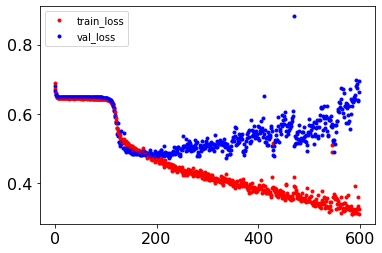

Finished Training
Test accuracy of the network on the 281 test images: 0.8327
Train accuracy of the network on the 841 train images: 0.8906
LogLoss = 5.7770


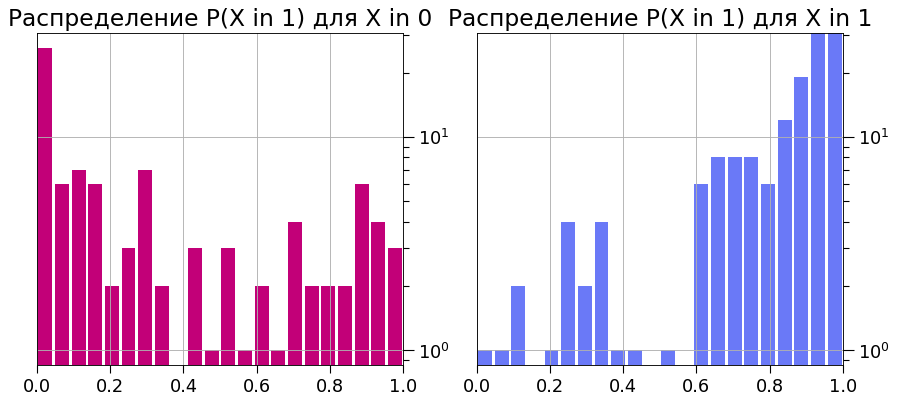

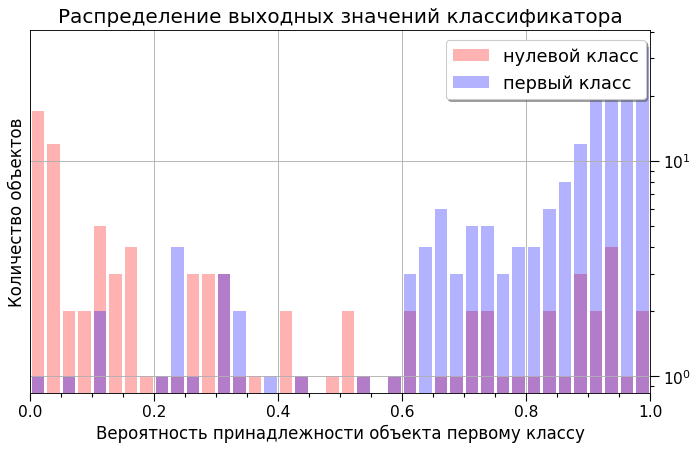

Test ROC-AUC: 0.8722, test PR-AUC: 0.9192


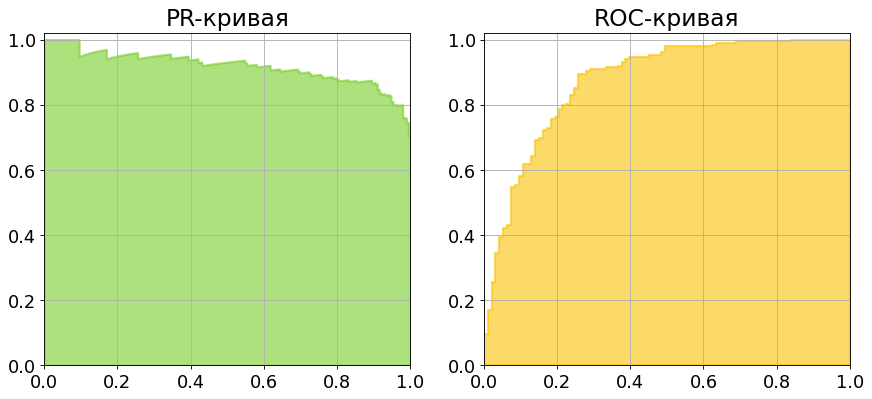

LogLoss:  mean = 5.7707, std = 0.4089
Accuracy: mean = 0.8329, std = 0.0118
AUC-ROC:  mean = 0.8724, std = 0.0123
AUC-PR:   mean = 0.9195, std = 0.0105


  0%|          | 0/600 [00:00<?, ?it/s]

[   10] error: 0.646
[   20] error: 0.645
[   30] error: 0.646
[   40] error: 0.644
[   50] error: 0.645
[   60] error: 0.646
[   70] error: 0.645
[   80] error: 0.645
[   90] error: 0.645
[  100] error: 0.645
[  110] error: 0.645
[  120] error: 0.643
[  130] error: 0.643
[  140] error: 0.638
[  150] error: 0.629
[  160] error: 0.594
[  170] error: 0.576
[  180] error: 0.566
[  190] error: 0.559
[  200] error: 0.540
[  210] error: 0.523
[  220] error: 0.499
[  230] error: 0.484
[  240] error: 0.481
[  250] error: 0.468
[  260] error: 0.466
[  270] error: 0.454
[  280] error: 0.464
[  290] error: 0.445
[  300] error: 0.442
[  310] error: 0.445
[  320] error: 0.438
[  330] error: 0.441
[  340] error: 0.427
[  350] error: 0.415
[  360] error: 0.410
[  370] error: 0.417
[  380] error: 0.405
[  390] error: 0.401
[  400] error: 0.396
[  410] error: 0.398
[  420] error: 0.391
[  430] error: 0.378
[  440] error: 0.395
[  450] error: 0.378
[  460] error: 0.378
[  470] error: 0.374
[  480] error

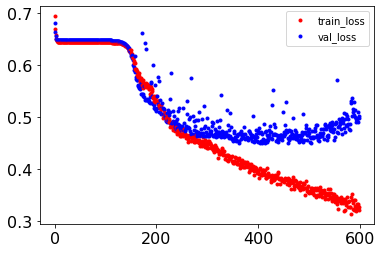

Finished Training
Test accuracy of the network on the 281 test images: 0.8078
Train accuracy of the network on the 841 train images: 0.8835
LogLoss = 6.6375


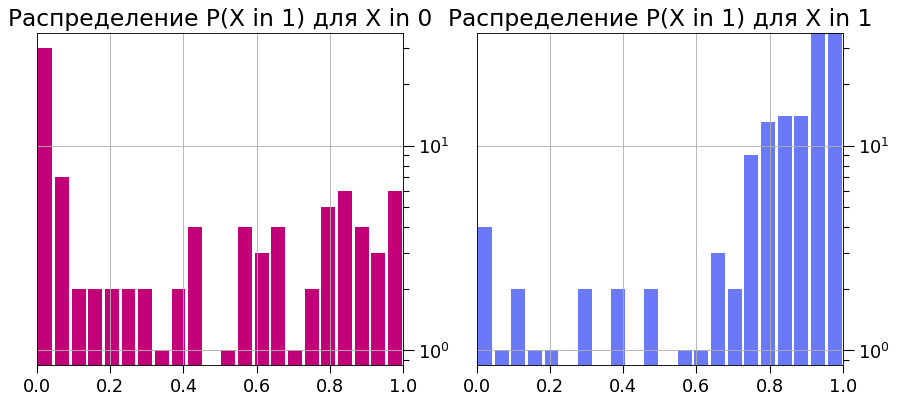

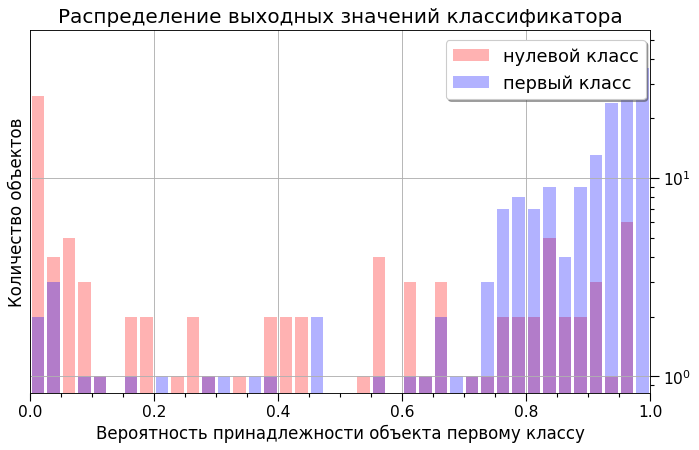

Test ROC-AUC: 0.8689, test PR-AUC: 0.9254


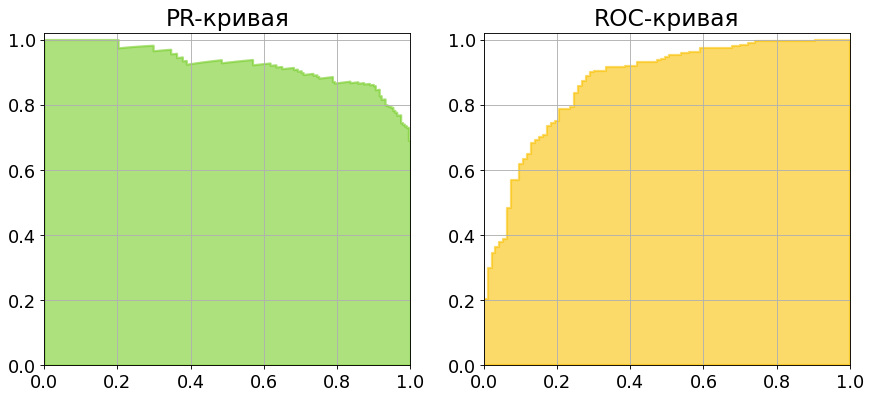

LogLoss:  mean = 6.6327, std = 0.4313
Accuracy: mean = 0.8080, std = 0.0125
AUC-ROC:  mean = 0.8691, std = 0.0121
AUC-PR:   mean = 0.9256, std = 0.0089


  0%|          | 0/600 [00:00<?, ?it/s]

[   10] error: 0.646
[   20] error: 0.645
[   30] error: 0.645
[   40] error: 0.645
[   50] error: 0.645
[   60] error: 0.645
[   70] error: 0.645
[   80] error: 0.645
[   90] error: 0.645
[  100] error: 0.645
[  110] error: 0.645
[  120] error: 0.645
[  130] error: 0.645
[  140] error: 0.645
[  150] error: 0.644
[  160] error: 0.645
[  170] error: 0.645
[  180] error: 0.644
[  190] error: 0.643
[  200] error: 0.641
[  210] error: 0.639
[  220] error: 0.628
[  230] error: 0.598
[  240] error: 0.567
[  250] error: 0.567
[  260] error: 0.547
[  270] error: 0.547
[  280] error: 0.533
[  290] error: 0.533
[  300] error: 0.530
[  310] error: 0.528
[  320] error: 0.513
[  330] error: 0.508
[  340] error: 0.505
[  350] error: 0.481
[  360] error: 0.486
[  370] error: 0.481
[  380] error: 0.477
[  390] error: 0.474
[  400] error: 0.479
[  410] error: 0.478
[  420] error: 0.466
[  430] error: 0.452
[  440] error: 0.460
[  450] error: 0.458
[  460] error: 0.435
[  470] error: 0.436
[  480] error

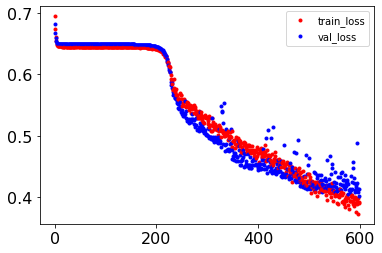

Finished Training
Test accuracy of the network on the 281 test images: 0.8470
Train accuracy of the network on the 841 train images: 0.8573
LogLoss = 5.2854


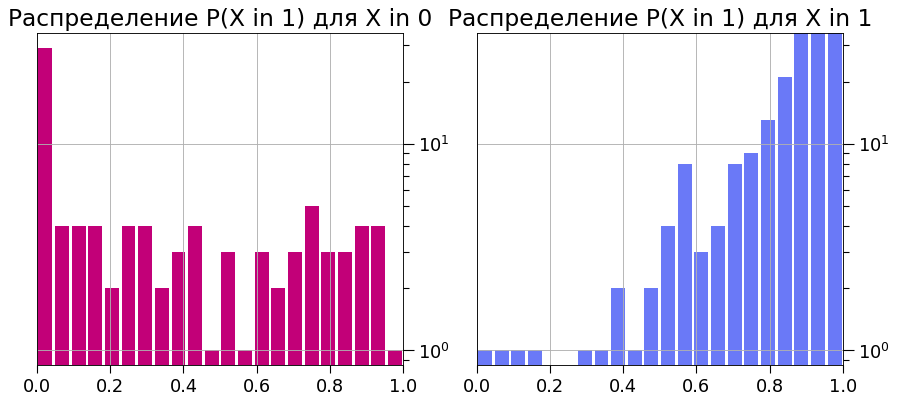

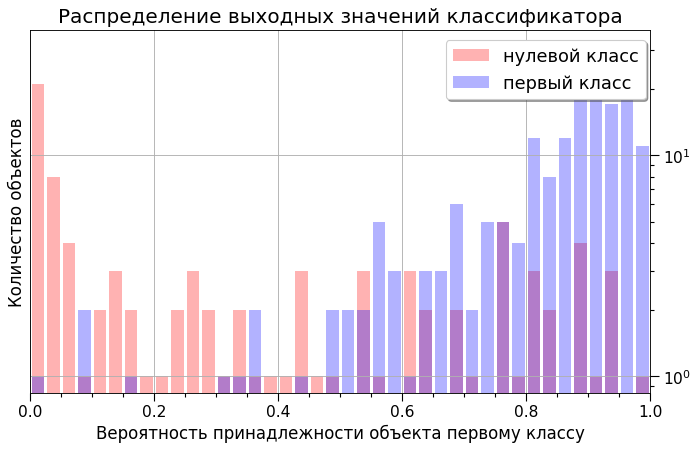

Test ROC-AUC: 0.8806, test PR-AUC: 0.9181


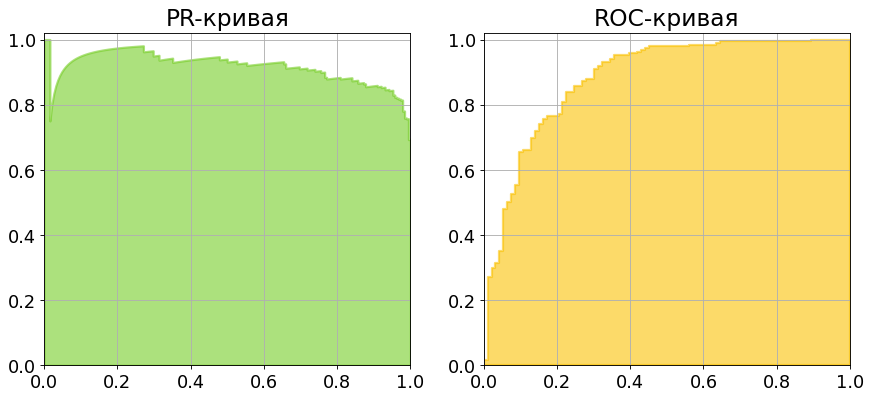

LogLoss:  mean = 5.2846, std = 0.3929
Accuracy: mean = 0.8470, std = 0.0114
AUC-ROC:  mean = 0.8804, std = 0.0120
AUC-PR:   mean = 0.9182, std = 0.0125


In [132]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
all_datas = [all_data_0, all_data_1, all_data_2]
all_target_classes_list = [all_target_classes_0, all_target_classes_1, all_target_classes_2]
for all_data, all_target_classes in zip(all_datas, all_target_classes_list):
    # train / test split data
    X_train, X_test_val, y_train, y_test_val = train_test_split(all_data, 
                                                        all_target_classes,
                                                        test_size=0.4,
                                                        random_state=179) #why is these num params?
    
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, 
                                                        y_test_val,
                                                        test_size=0.5,
                                                        random_state=179)
    # normalize input data
    X_train_norm = np.array((X_train - X_train.mean()) / X_train.std(), dtype=np.float32)
    X_test_norm = np.array((X_test - X_train.mean()) / X_train.std(), dtype=np.float32)
    X_val_norm = np.array((X_val - X_train.mean()) / X_train.std(), dtype=np.float32)

    # convert train data to tensors
    X_train_tensor = torch.from_numpy(X_train_norm)
    y_train_tensor = torch.from_numpy(np.array(y_train, dtype=np.float32))

    # create train data loader
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                              shuffle=True, num_workers=2)

    # convert test data to tensors
    X_test_tensor = torch.from_numpy(X_test_norm)
    y_test_tensor = torch.from_numpy(np.array(y_test, dtype=np.float32))

    # create test data loader
    test_data = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                             shuffle=False, num_workers=2)
    
    # convert val data to tensors
    X_val_tensor = torch.from_numpy(X_val_norm)
    y_val_tensor = torch.from_numpy(np.array(y_val, dtype=np.float32))
    
    # create val data loader
    val_data = TensorDataset(X_val_tensor, y_val_tensor)
    valloader = torch.utils.data.DataLoader(val_data, batch_size=1,
                                             shuffle=False, num_workers=2)
    
    net = Net()
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001)#, momentum=0.8)
    epochs = np.arange(600)
    
    best_loss_val = float('inf')
    best_state_on_val = None
    
    for epoch in tqdm(epochs):  # loop over the dataset multiple times
        epoch_loss = 0.0
        net.train()
        for info in trainloader:
            # get the inputs; info is a list of [inputs, labels]
            inputs, labels = info

            # zero the parameter gradients
            for param in net.parameters():
                param.grad = None

            # forward + backward + optimize
            outputs = net(inputs).reshape(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            #plt.plot(epoch, epoch_loss, 'o', color='red', label='loss')
            
        # print mean loss for the epoch
        cur_loss = epoch_loss / X_train_norm.shape[0]
        plt.plot(epoch, cur_loss, '.', color='red')
        if (epoch + 1) % 10 == 0:
            print('[%5d] error: %.3f' % (epoch + 1, cur_loss))
        
        net.eval()
        epoch_loss_val = 0.0
        for info in valloader:
            # get the inputs; info is a list of [inputs, labels]
            inputs, labels = info

            # forward
            outputs = net(inputs).reshape(1)
            loss = criterion(outputs, labels)

            epoch_loss_val += loss.item()
        
        cur_loss_val = epoch_loss_val / X_val_norm.shape[0]
        plt.plot(epoch, cur_loss_val, '.', color='blue')
            
        if epoch_loss_val <= best_loss_val:
            best_loss_val = epoch_loss_val
            best_state_val = net.state_dict()
            
    plt.legend(['train_loss', 'val_loss'])        
    plt.show()
    
    net.load_state_dict(best_state_val)
    print('Finished Training')
    
    # check models' accuracy
    test_accuracy = get_model_accuracy(net, testloader)
    train_accuracy = get_model_accuracy(net, trainloader)

    print('Test accuracy of the network on the %d test images: %.4f' % 
      (X_test_norm.shape[0], test_accuracy))
    print('Train accuracy of the network on the %d train images: %.4f' % 
      (X_train_norm.shape[0], train_accuracy))
    y_test = []
    y_probs = []
    y_probs_0 = []
    y_probs_1 = []

    with torch.no_grad():
        for test_info in testloader:
            images, test_labels = test_info
            test_outputs = net(images)

            # get output value
            prob = test_outputs.item()

            # check true target valur    
            true_class = int(test_labels.item())

            # compare output to threshold
            if true_class == 0:
                y_probs_0.append(prob)
            else:
                y_probs_1.append(prob)

            # get predicted target value
            y_test.append(true_class)
            y_probs.append(prob)

    y_test = np.array(y_test)
    y_probs = np.array(y_probs)

    assert np.array(y_probs).min() >= 0
    assert np.array(y_probs).max() <= 1
    
    N = len(y_probs)

    # sample predicted values
    sample_coeffs = np.random.randint(0, N, (10000, 1000))
    sample_prob = y_probs[sample_coeffs]
    sample_test = y_test[sample_coeffs]
    sample_pred = sample_prob > 0.5

    assert len(sample_test) == len(sample_prob)
    assert len(sample_prob) == len(sample_pred)
    T = len(sample_test)

    # calculated mean accuracy
    accuracy = [(sample_pred[i] == sample_test[i]).mean() for i in range(T)]
    y_pred = np.array(y_probs) > 0.5
    print("LogLoss = %.4f" % log_loss(y_test, y_pred))

    # calculate mean log loss
    logloss = [log_loss(sample_test[i], sample_pred[i]) for i in range(T)]
    # compare distibution of output values

    rc('xtick', labelsize=16)
    rc('ytick', labelsize=16)

    fig = plt.figure(dpi=80, figsize=(13, 5.5))

    bins_number = 22
    step = 1 / bins_number
    hist_0, _ = np.histogram(y_probs_0, bins=bins_number, range=(0.0, 1.0))
    hist_1, _ = np.histogram(y_probs_1, bins=bins_number, range=(0.0, 1.0))
    x = np.arange(0 + step/2, 1, step)

    ax1 = fig.add_subplot(121)
    ax1.yaxis.tick_right()
    plt.title("Распределение P(X in 1) для X in 0", fontsize=21, pad=7)

    ax1.bar(x, hist_0, color="xkcd:magenta", width=0.038, log=True)
    ax1.minorticks_on()
    ax1.tick_params('y', length=10, width=1, which='major')
    ax1.tick_params('y', length=5, width=1, which='minor')
    ax1.tick_params('x', length=7, width=1, which='major')
    ax1.tick_params('x', length=0, width=1, which='minor')
    plt.xlim((0.0, 1.0))
    plt.ylim((ax1.get_ylim()[0], int(ax1.get_ylim()[1]) // 100 * 100))
    plt.grid(True)

    ax2 = fig.add_subplot(122)
    ax2.yaxis.tick_right()
    plt.title("Распределение P(X in 1) для X in 1", fontsize=21, pad=7)

    ax2.bar(x, hist_1, color="xkcd:cornflower", width=0.038, log=True)
    ax2.minorticks_on()
    ax2.tick_params('y', length=10, width=1, which='major')
    ax2.tick_params('y', length=5, width=1, which='minor')
    ax2.tick_params('x', length=7, width=1, which='major')
    ax2.tick_params('x', length=0, width=1, which='minor')
    plt.xlim((0.0, 1.0))
    plt.ylim(ax1.get_ylim())
    plt.grid(True)

    plt.show()

    # compare distibution of output values

    rc('xtick', labelsize=14)
    rc('ytick', labelsize=14)

    fig = plt.figure(dpi=80, figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.yaxis.tick_right()
    plt.title("Распределение выходных значений классификатора", fontsize=18, pad=7)
    plt.xlabel("Вероятность принадлежности объекта первому классу", fontsize=15)
    plt.ylabel("Количество объектов", fontsize=15)

    bins_number = 40
    step = 1 / bins_number
    hist_0, _ = np.histogram(y_probs_0, bins=bins_number, range=(0.0, 1.0))
    hist_1, _ = np.histogram(y_probs_1, bins=bins_number, range=(0.0, 1.0))
    x = np.arange(0 + step/2, 1, step)

    plt.bar(x, hist_0, color='r', width=0.02, log=True, label="нулевой класс", alpha=0.3)
    plt.bar(x, hist_1, color='b', width=0.02, log=True, label="первый класс", alpha=0.3)

    ax.minorticks_on()
    ax.tick_params('y', length=8, width=1, which='major')
    ax.tick_params('y', length=4, width=1, which='minor')
    ax.tick_params('x', length=7, width=1, which='major')
    ax.tick_params('x', length=4, width=1, which='minor')

    plt.xlim((0.0, 1.0))
    plt.grid(True)
    plt.legend(frameon=True, loc=(0.67, 0.81), fontsize=16, shadow=0.1)

    plt.show()
    
    rc('xtick', labelsize=16)
    rc('ytick', labelsize=16)

    print("Test ROC-AUC: %.4f, test PR-AUC: %.4f" % (roc_auc_score(y_test, y_probs), 
                                                     average_precision_score(y_test, y_probs)))

    # calculate mean AUC-ROC & AUC-PR
    auc_roc = [roc_auc_score(sample_test[i], sample_prob[i]) for i in range(T)]
    auc_pr = [average_precision_score(sample_test[i], sample_prob[i]) for i in range(T)]

    precision, recall, _ = precision_recall_curve(y_test, y_probs)

    fig = plt.figure(dpi=80, figsize=(13, 5.5))
    ax = fig.add_subplot(121)
    plt.grid(True)
    ax.set_title("PR-кривая", fontsize=21, pad=7)
    ax.fill_between(recall, precision, alpha=0.6, color="xkcd:apple green", lw=2)
    ax.set_xlim(0, 1.)
    ax.set_ylim(0, 1.02)

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    ax = fig.add_subplot(122)
    plt.grid(True)
    ax.set_title("ROC-кривая", fontsize=21, pad=7)
    ax.fill_between(fpr, tpr, alpha=0.6, color="xkcd:goldenrod", lw=2)
    ax.set_xlim(0, 1.)
    ax.set_ylim(0, 1.02)

    plt.show()
    
    print("LogLoss:  mean = %.4f, std = %.4f" % (np.mean(logloss), np.std(logloss)))
    print("Accuracy: mean = %.4f, std = %.4f" % (np.mean(accuracy), np.std(accuracy)))
    print("AUC-ROC:  mean = %.4f, std = %.4f" % (np.mean(auc_roc), np.std(auc_roc)))
    
#     if np.mean(auc_roc) > current_auc_roc:
#         current_auc_roc = auc_roc
        
#         current_kernel1_size = 
#         current_kernel2_size = 
#         current_kernel3_size =
        
#         current_dropout = 
        
#         current_max_pool = 
        
#         current_n_obs = 
        
    print("AUC-PR:   mean = %.4f, std = %.4f" % (np.mean(auc_pr), np.std(auc_pr)))
    
    

# N_OBS = 100

## C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()


LogLoss:  mean = 5.5353, std = 0.4033

Accuracy: mean = 0.8397, std = 0.0117

AUC-ROC:  mean = 0.8738, std = 0.0123

AUC-PR:   mean = 0.9165, std = 0.0127


## C(1.0)*RBF([1, 1]) + Matern() + WhiteKernel()


LogLoss:  mean = 5.4007, std = 0.3972

Accuracy: mean = 0.8436, std = 0.0115

AUC-ROC:  mean = 0.8847, std = 0.0116

AUC-PR:   mean = 0.9296, std = 0.0100


## C(1.0)*RBF([1, 1]) + WhiteKernel()


LogLoss:  mean = 7.4943, std = 0.4548

Accuracy: mean = 0.7830, std = 0.0132

AUC-ROC:  mean = 0.8535, std = 0.0125

AUC-PR:   mean = 0.9175, std = 0.0100



# N_OBS = 50

## C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()


LogLoss:  mean = 4.7932, std = 0.3810

Accuracy: mean = 0.8612, std = 0.0110

AUC-ROC:  mean = 0.8855, std = 0.0120

AUC-PR:   mean = 0.9210, std = 0.0123


## C(1.0)*RBF([1, 1]) + Matern() + WhiteKernel()


LogLoss:  mean = 5.6417, std = 0.4093

Accuracy: mean = 0.8367, std = 0.0118

AUC-ROC:  mean = 0.8766, std = 0.0125

AUC-PR:   mean = 0.9163, std = 0.0119


## C(1.0)*RBF([1, 1]) + WhiteKernel()


LogLoss:  mean = 4.6632, std = 0.3732

Accuracy: mean = 0.8650, std = 0.0108

AUC-ROC:  mean = 0.8744, std = 0.0130

AUC-PR:   mean = 0.9105, std = 0.0128


# N_OBS = 10


## C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()


LogLoss:  mean = 5.6607, std = 0.4036

Accuracy: mean = 0.8361, std = 0.0117

AUC-ROC:  mean = 0.8705, std = 0.0131

AUC-PR:   mean = 0.9046, std = 0.0137


## C(1.0)*RBF([1, 1]) + Matern() + WhiteKernel()


LogLoss:  mean = 4.7964, std = 0.3805

Accuracy: mean = 0.8611, std = 0.0110

AUC-ROC:  mean = 0.8876, std = 0.0124

AUC-PR:   mean = 0.9157, std = 0.0137


## C(1.0)*RBF([1, 1]) + WhiteKernel()


LogLoss:  mean = 5.2761, std = 0.3927

Accuracy: mean = 0.8472, std = 0.0114

AUC-ROC:  mean = 0.8845, std = 0.0119

AUC-PR:   mean = 0.9266, std = 0.0100

In [9]:
# # model for binary classificiation: Supernova Ia VS others

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 4, kernel_size=(50, 2))
#         self.conv2 = nn.Conv2d(4, 8, kernel_size=(100, 1))
#         self.conv3 = nn.Conv1d(8, 16, kernel_size=(100, 1))
#         self.pool = nn.MaxPool2d(1, 2) # 2,1
#         self.dropout = nn.Dropout(0.2)
#         self.fc1 = nn.Linear(14032, 64)#(1978, 64) # 3824
#         self.fc2 = nn.Linear(64, 1)

#     def forward(self, x):
#         x = F.leaky_relu(self.conv1(x))
#         x = F.leaky_relu(self.conv2(x))
#         x = F.leaky_relu(self.conv3(x))
#         x = self.pool(x)
#         x = self.dropout(x)
        
#         x = x.view(-1, 14032)#)31808) #3824
        
#         x = F.relu(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))
#         return x